# 1. NN Difficulty evaluator

In [67]:
import matplotlib
import torch
import torch.nn.functional as F
from IPython.core.display import display, clear_output
from matplotlib import pyplot as plt
from torch.nn import LeakyReLU
from torch.optim import Adam

from evaluators import DirectEvaluator
from helpers import set_matplotlib_colors
from renderer import render_single_enemy
from shared_parameters import *
from utils import TrainUntil, MLP, save

set_matplotlib_colors(matplotlib)

*Suppose* we have an *oracle* that can correctly accurately evaluate the level difficulty.
Then we can train a neural network to learn from that oracle.

Here we use the `DirectEvaluator` as the oracle

In [68]:
oracle = DirectEvaluator(connector_length, max_angle, enemy_radius, bob_radius)

Display a randomly generated state

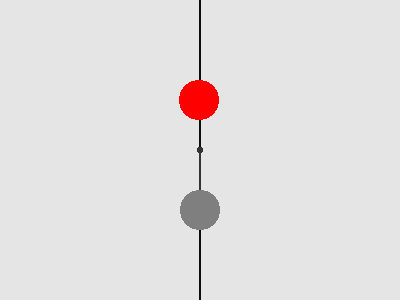

In [69]:
x = np.linspace(enemy_x_min, enemy_x_max, subdivisions)
enemy_x = np.random.choice(x, 1).item()
image = render_single_enemy(enemy_x, resolution=0.5)

display(image)
save(image, "./data/example.png")

Difficulty evaluator training loop

In [70]:
difficulties = torch.from_numpy(oracle.evaluate(x)).to(torch.float32).unsqueeze(1)
states = torch.tensor([[x1] for x1 in x], dtype=torch.float32)

evaluator = MLP(1, 1, [4, 4], activation=LeakyReLU())
optim_evaluator = Adam(evaluator.parameters(), lr=0.001)

with TrainUntil(0.0001, 100) as trainer:
    while not trainer.done:
        indices = np.random.choice(states.shape[0], 25, replace=False)
        s = states[indices]
        predicted = evaluator(s)
        loss = F.mse_loss(predicted, difficulties[indices])

        optim_evaluator.zero_grad()
        loss.backward()
        optim_evaluator.step()

        if (trainer.iteration + 1) % 100 == 0:
            clear_output(wait=True)
            print(trainer.iteration + 1, loss.item())

        trainer.loss = loss

print(trainer.iteration, "iterations to train estimator")

1700 7.863262726459652e-05
Done after 1794 iteration(s). Loss: 0.000032
1794 iterations to train estimator


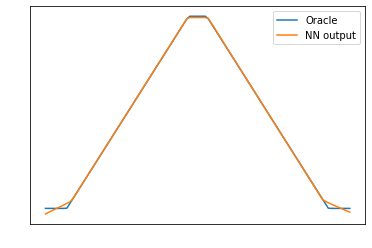

In [71]:
predicted = evaluator(states)

axs = plt.subplot()
axs.plot(x, difficulties)
axs.plot(x, predicted.detach().numpy())
axs.legend(["Oracle", "NN output"])
plt.show()

Now we can train the generator in a fully differentiable way, using
the trained level difficulty evaluator.

    Interrupt the cell below once you feel like it.

The reason for interruption is that in this particular case (ang generally)
we may not always have the states in our environment, that
correspond to some difficulties.

For example, here there are no states with the difficulty $1$. Thus,
our generator will not always be able to reach (near) zero error.

In [76]:
generator = MLP(1, 1, [2, 2], activation=LeakyReLU())
optim_generator = Adam(generator.parameters(), lr=0.001)

difficulties = torch.linspace(0, 1, 1000).unsqueeze(-1)

for p in evaluator.parameters():
    p.requires_grad = False

batch_size = 25

with TrainUntil(0.0001, 1) as trainer:
    while not trainer.done:
        indices = torch.randperm(difficulties.shape[0])[:100]
        d_in = difficulties[indices]

        states = generator(d_in)
        d_out = evaluator(states)

        loss = F.mse_loss(d_in, d_out)

        optim_generator.zero_grad()
        loss.backward()
        optim_generator.step()

        if (trainer.iteration + 1) % 100 == 0:
            clear_output(wait=True)
            print(trainer.iteration + 1, loss.item())

        trainer.loss = loss

print(trainer.iteration, loss.item())

4100 0.0006143064238131046
Done after 4186 iteration(s). Loss: 0.000025
4186 2.5469074898865074e-05


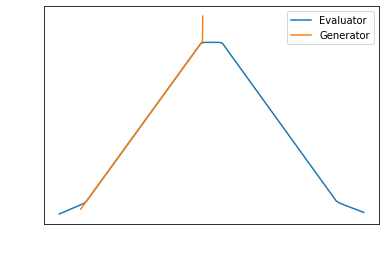

In [78]:
d_in = torch.linspace(0, 1, 100).unsqueeze(1)

with torch.no_grad():
    states = generator(d_in)

states = states.numpy()

axs = plt.subplot()
axs.set_xlabel("Enemy x")
axs.set_ylabel("Difficulty")

axs.plot(x, evaluator(torch.tensor([[x1] for x1 in x], dtype=torch.float32)))
axs.plot(states, d_in)

axs.legend(["Evaluator", "Generator"])

plt.show()

### Takeaway

1. The approach works for this setting (and rather reliably)
2. The generator only generates positions for the one side

    **It does not generate *several different* positions for the *same* difficulty**

### Some generated images

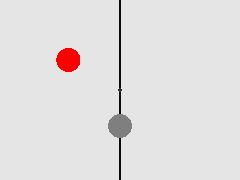

0.0

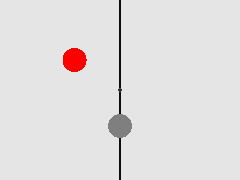

0.1111111119389534

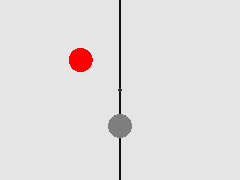

0.2222222238779068

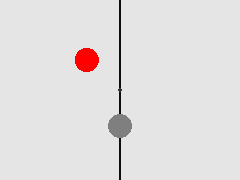

0.3333333432674408

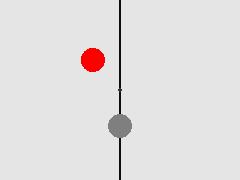

0.4444444477558136

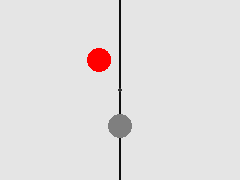

0.5555555820465088

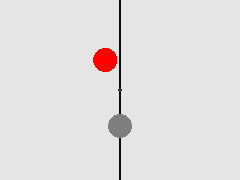

0.6666666269302368

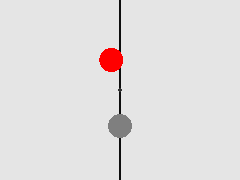

0.7777777910232544

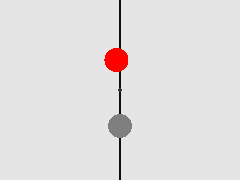

0.8888888955116272

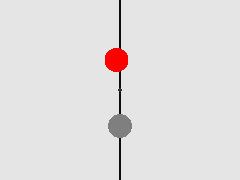

1.0

In [79]:
d_in = torch.linspace(0, 1, 10).unsqueeze(1)

with torch.no_grad():
    enemy_xs = generator(d_in)

images = [render_single_enemy(enemy_x, resolution=0.3) for enemy_x in enemy_xs]

for image, d in zip(images, d_in):
    display(image)
    display(d.item())

Finally, let's try another approach,
training evaluator and generator simultaneously

In [80]:
# Generator
generator = MLP(1, 1, [2, 2], activation=LeakyReLU())
optim_generator = Adam(generator.parameters(), lr=0.001)

# Evaluator
evaluator = MLP(1, 1, [4, 4], activation=LeakyReLU())
optim_evaluator = Adam(evaluator.parameters(), lr=0.01)

# Oracle (we already have it)

# Dataset (input difficulties) that we will sample from
difficulties = torch.linspace(0, 1, 1000).unsqueeze(-1)

iteration = 0
while True:
    indices = torch.randperm(difficulties.shape[0])[:50]
    d_in = difficulties[indices]

    states = generator(d_in)
    d_out = evaluator(states)

    loss_generator = F.mse_loss(d_in, d_out)

    # Update the generator
    optim_generator.zero_grad()
    loss_generator.backward()
    optim_generator.step()

    states = states.detach()

    d_out = evaluator(states)
    real_d_out = oracle(states)
    loss_evaluator = F.mse_loss(d_out, real_d_out)

    # Update evaluator
    optim_evaluator.zero_grad()
    loss_evaluator.backward()
    optim_evaluator.step()

    loss = loss_generator + loss_evaluator

    if (iteration + 1) % 100 == 0:
        clear_output(wait=True)
        print(f"It.: {iteration + 1}, "
              f"(G) {loss_generator.item():.5f} + "
              f"(E) {loss_evaluator.item():.5f} = "
              f"{loss.item():.5f}")

    if loss < 0.0001:
        break

    iteration += 1

clear_output(wait=True)
print(f"It.: {iteration + 1}, "
      f"(G){loss_generator:.5f} + "
      f"(E){loss_evaluator.item():.5f} = "
      f"{loss:.5f}")

It.: 80421, (G)0.00008 + (E)0.00000 = 0.00008


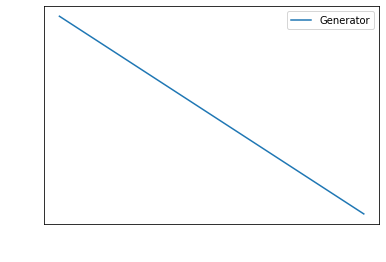

In [81]:

d_in = torch.linspace(0, 1, 100).unsqueeze(1)

with torch.no_grad():
    states = generator(d_in)

axs = plt.subplot()
axs.set_xlabel("Enemy x")
axs.set_ylabel("Difficulty")

axs.plot(states, d_in)

axs.legend(["Generator"])

plt.show()

#### Looks like this kinda works

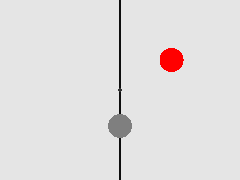

0.0

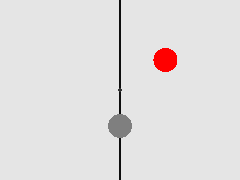

0.1111111119389534

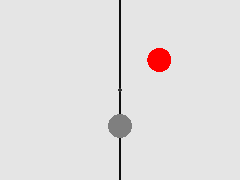

0.2222222238779068

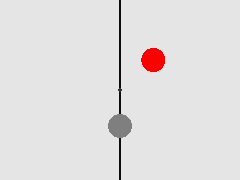

0.3333333432674408

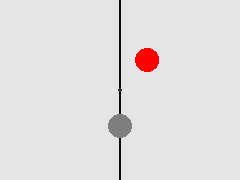

0.4444444477558136

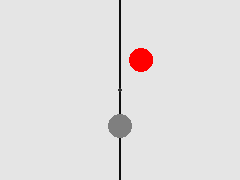

0.5555555820465088

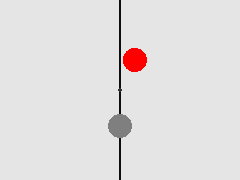

0.6666666269302368

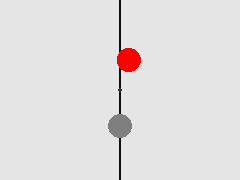

0.7777777910232544

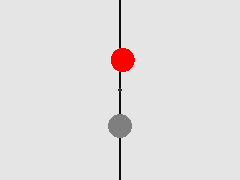

0.8888888955116272

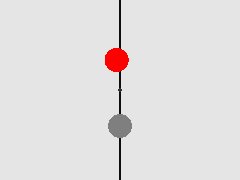

1.0

In [82]:
d_in = torch.linspace(0, 1, 10).unsqueeze(1)

with torch.no_grad():
    enemy_xs = generator(d_in)

images = [render_single_enemy(enemy_x, resolution=0.3) for enemy_x in enemy_xs]

for image, d in zip(images, d_in):
    display(image)
    display(d.item())